# 1.Reading and Plotting Data

In [1]:
!pip install --no-cache-dir xarray[complete] zarr gcsfs fsspec

In [2]:
import gcsfs
import xarray as xr

gcs_path = "gs://weatherbench2/datasets/hres_t0/2016-2022-6h-512x256_equiangular_conservative.zarr"

fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

mapper = fs.get_mapper(gcs_path)

ds = xr.open_dataset(
    gcs_path,
    engine="zarr",
    consolidated=True,
    backend_kwargs={"storage_options": {"token": "anon"}}
)


print(ds.data_vars)

Data variables:
    10m_u_component_of_wind  (time, longitude, latitude) float32 5GB ...
    10m_v_component_of_wind  (time, longitude, latitude) float32 5GB ...
    10m_wind_speed           (time, longitude, latitude) float32 5GB ...
    2m_temperature           (time, longitude, latitude) float32 5GB ...
    geopotential             (time, level, longitude, latitude) float32 70GB ...
    mean_sea_level_pressure  (time, longitude, latitude) float32 5GB ...
    specific_humidity        (time, level, longitude, latitude) float32 70GB ...
    surface_pressure         (time, longitude, latitude) float32 5GB ...
    temperature              (time, level, longitude, latitude) float32 70GB ...
    total_precipitation_6hr  (time, longitude, latitude) float32 5GB ...
    u_component_of_wind      (time, level, longitude, latitude) float32 70GB ...
    v_component_of_wind      (time, level, longitude, latitude) float32 70GB ...
    vertical_velocity        (time, level, longitude, latitude) floa

In [3]:
time_range = ds['time'].min().values, ds['time'].max().values
level_range = ds['level'].min().values, ds['level'].max().values

time_range, level_range

((np.datetime64('2016-01-01T00:00:00.000000000'),
  np.datetime64('2022-12-31T18:00:00.000000000')),
 (array(50, dtype=int32), array(1000, dtype=int32)))

In [4]:
lat_range  = ds['latitude'].min().values, ds['latitude'].max().values
long_range = ds['longitude'].min().values, ds['longitude'].max().values

lat_range, long_range

((array(-89.6484375), array(89.6484375)), (array(0.), array(359.296875)))

In [5]:
#the dataset has a 256 × 512 grid:
#256 latitude points (from -89.65° to 89.65°)
#512 longitude points (from 0° to 359.3°)

ds['latitude'].shape, ds['longitude'].shape

((256,), (512,))

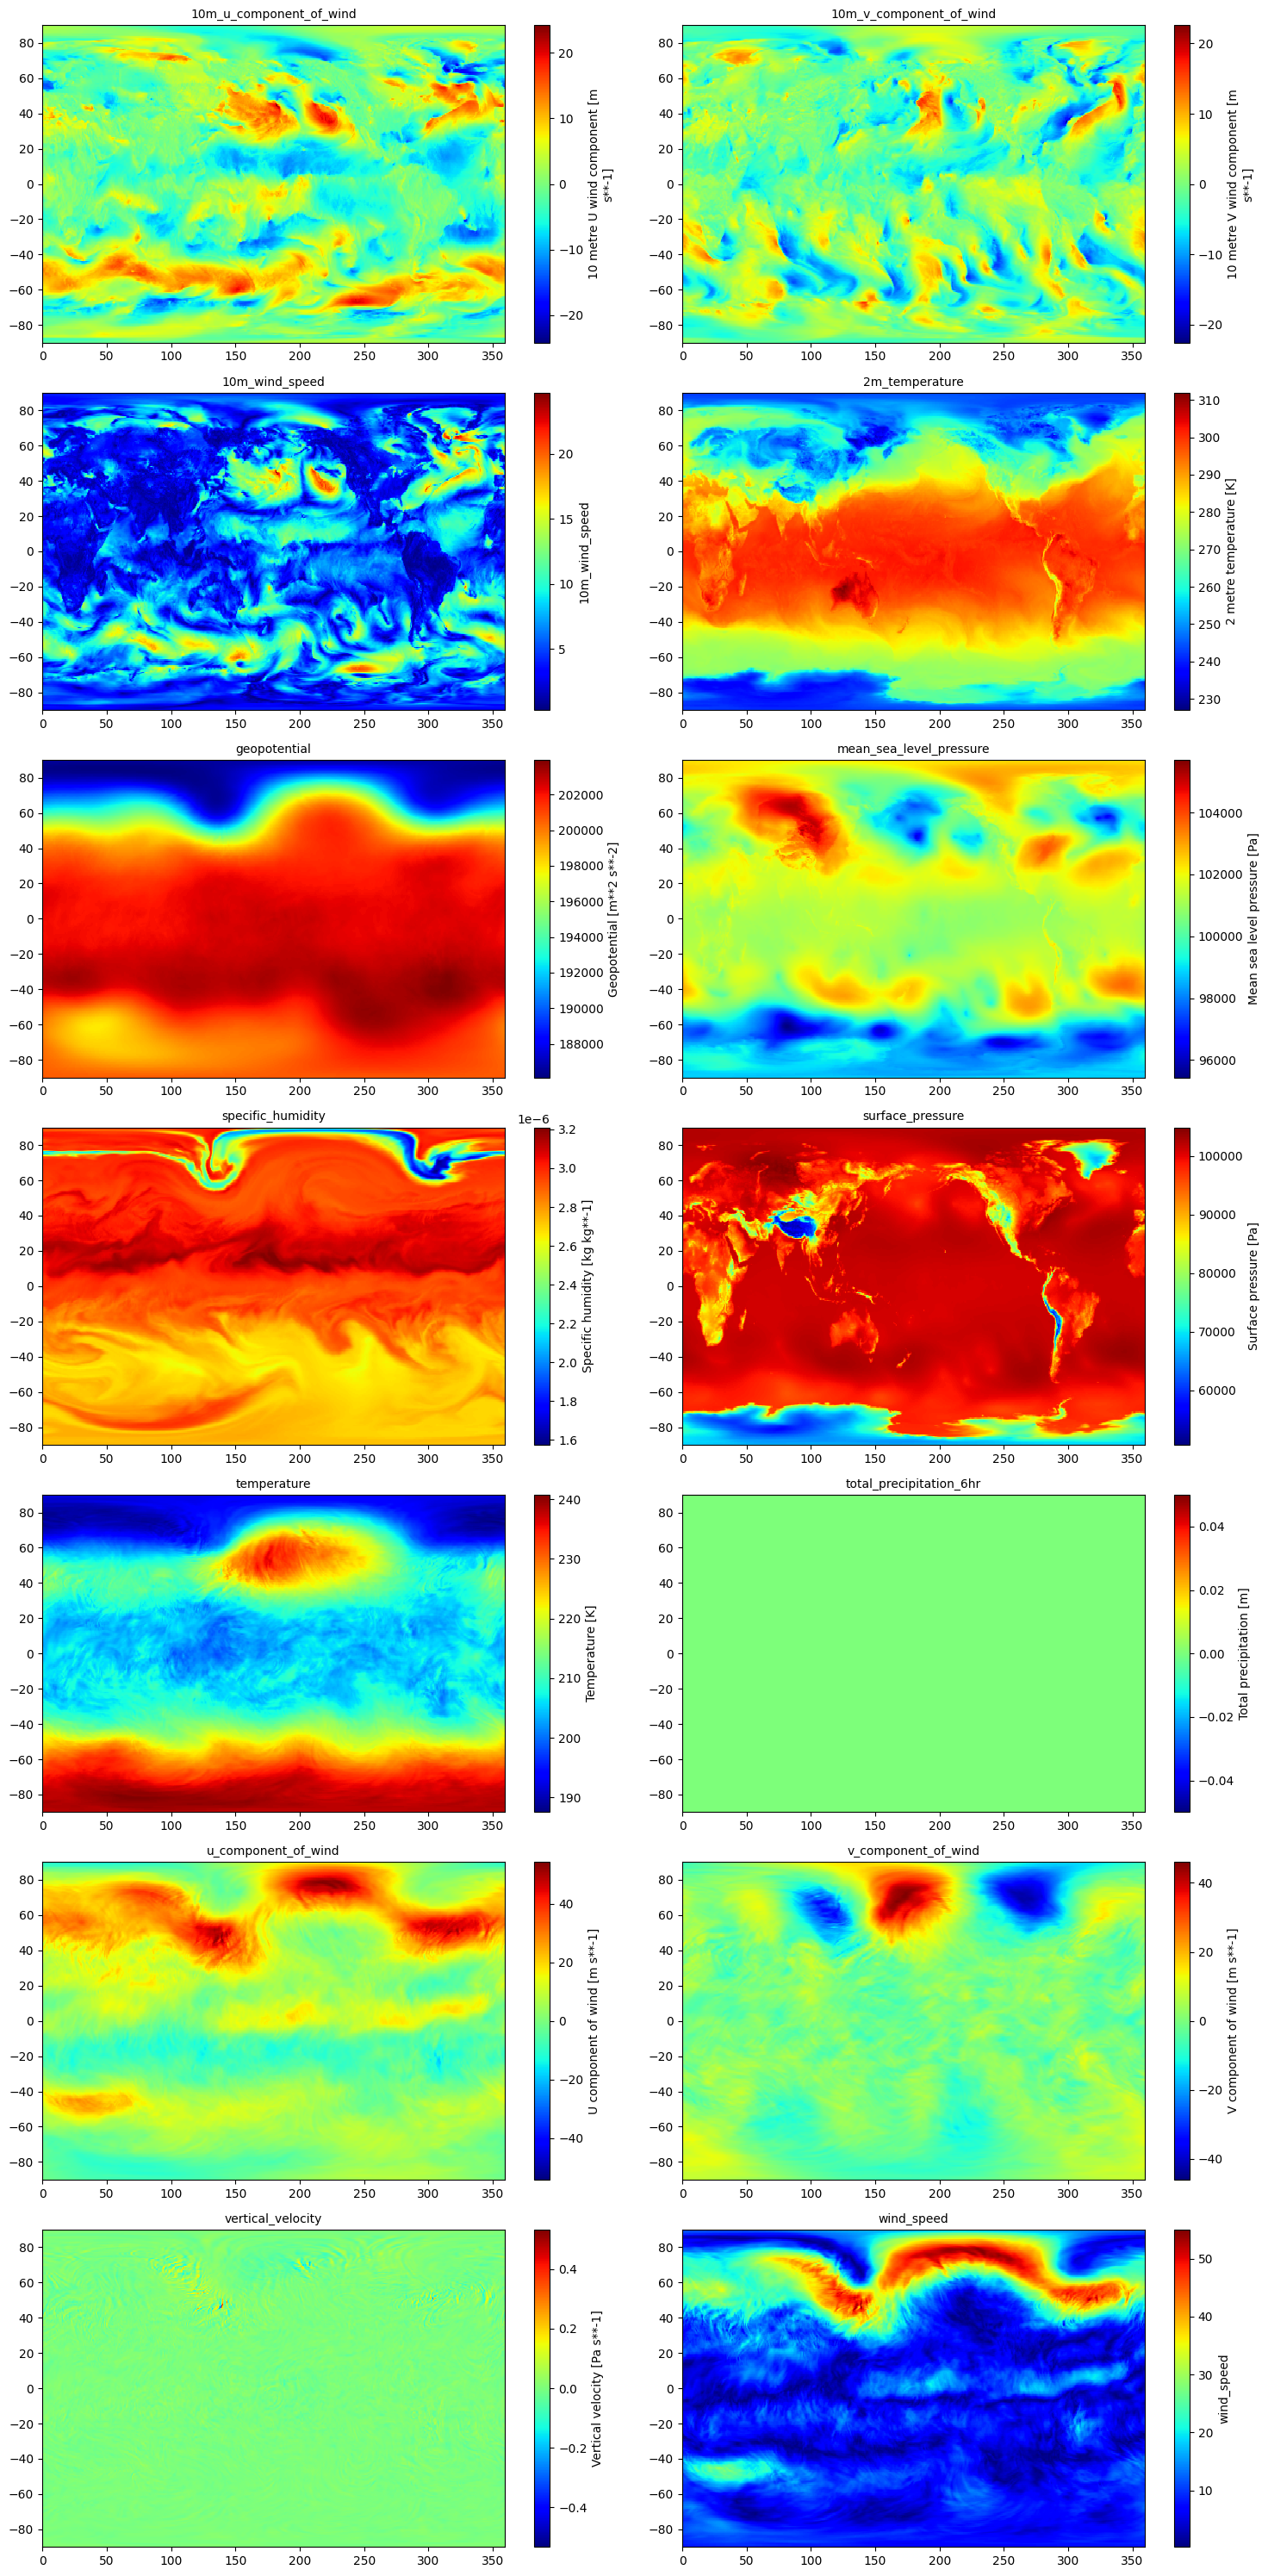

In [6]:
import matplotlib.pyplot as plt

#Plotting all 14 variables at a given level and time

random_time_idx = 20
random_level_idx = 0

subset = ds.isel(time=random_time_idx)

variables = list(subset.data_vars)

fig, axes = plt.subplots(7, 2, figsize=(15, 30))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]

    if 'level' in subset[var].dims:
        data = subset[var].isel(level=random_level_idx).T
    else:
        data = subset[var].T

    data.plot(ax=ax, cmap='jet', add_colorbar=True)
    ax.set_title(var, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

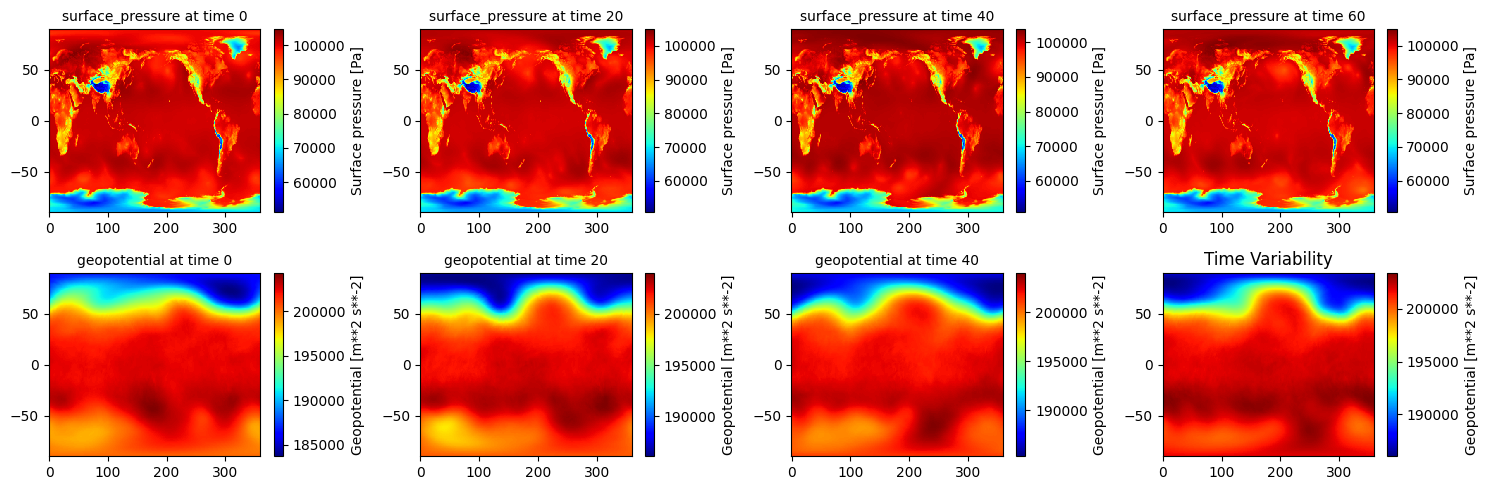

In [7]:
#Plotting two variables as a function of time

time_indices = [0, 20, 40, 60]
variables_to_plot = ['surface_pressure', 'geopotential']

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.flatten()

for i, var in enumerate(variables_to_plot):
    for j, time_idx in enumerate(time_indices):
        ax = axes[i * 4 + j]
        subset = ds.isel(time=time_idx)

        if 'level' in subset[var].dims:
            data = subset[var].isel(level=0).T
        else:
            data = subset[var].T

        data.plot(ax=ax, cmap='jet')
        ax.set_title(f'{var} at time {time_idx}', fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

plt.title("Time Variability")
plt.tight_layout()
plt.show()

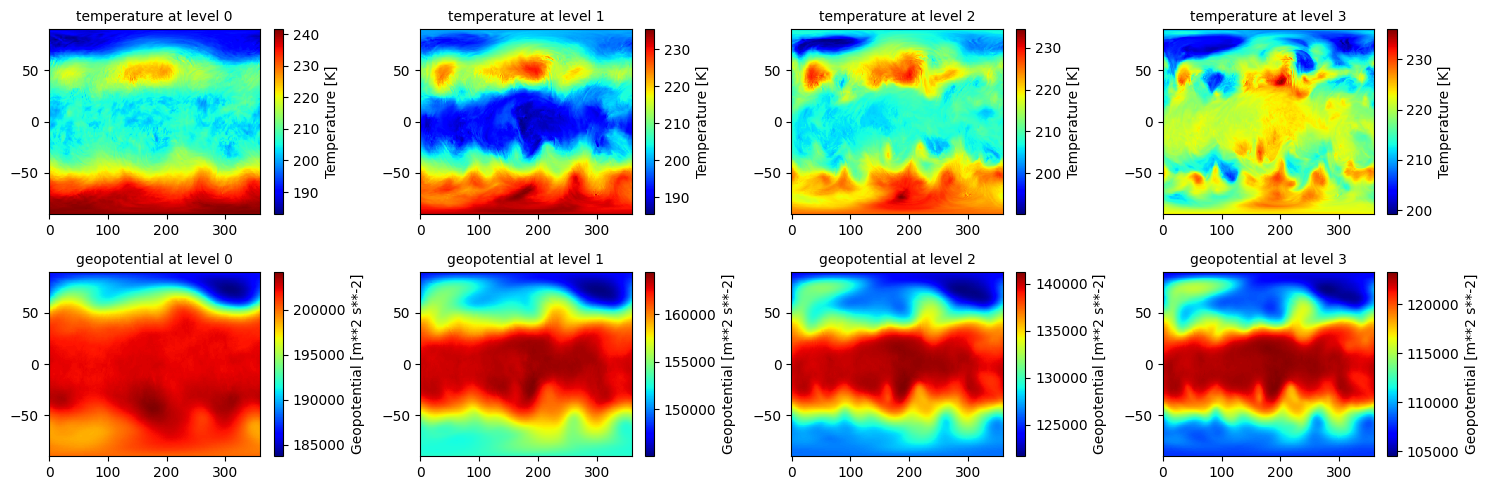

In [8]:
#Plotting two variables as a function of level


level_indices = [0, 1, 2, 3]
variables_to_plot = ['temperature', 'geopotential']

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.flatten()

for i, var in enumerate(variables_to_plot):
    for j, level_idx in enumerate(level_indices):
        ax = axes[i * 4 + j]
        data = ds[var].isel(time = 0, level=level_idx).T


        data.plot(ax=ax, cmap='jet', add_colorbar=True)
        ax.set_title(f'{var} at level {level_idx}', fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [9]:
#Defining a dataloader

import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

class WeatherDataset(Dataset):
    def __init__(self, ds, variables, lead_time=6, normalize=True):
        """
        Args:
            ds (xarray.Dataset): The dataset.
            variables (list): List of variable names to include.
            lead_time (int): How many timesteps ahead to predict.
            normalize (bool): Whether to normalize data.
        """
        self.ds = ds
        self.variables = variables
        self.lead_time = lead_time
        self.normalize = normalize

        self.time_steps = len(ds.time) - lead_time  # Exclude last 'lead_time' steps
        self.mean = None
        self.std = None

        # Compute normalization statistics
        if normalize:
            self.mean = {var: ds[var].mean().values for var in variables}
            self.std = {var: ds[var].std().values for var in variables}

    def __len__(self):
        return self.time_steps  # Number of available time steps

    def __getitem__(self, idx):
        """Return input (past frame) and target (future frame)"""
        input_time = idx
        target_time = idx + self.lead_time

        input_data = []
        target_data = []

        for var in self.variables:
            # Select data for the given time index
            if "level" in self.ds[var].dims:
                data_input = self.ds[var].isel(time=input_time, level=0).values
                data_target = self.ds[var].isel(time=target_time, level=0).values
            else:
                data_input = self.ds[var].isel(time=input_time).values
                data_target = self.ds[var].isel(time=target_time).values

            if self.normalize:
                data_input = (data_input - self.mean[var]) / (self.std[var] + 1e-8)
                data_target = (data_target - self.mean[var]) / (self.std[var] + 1e-8)

            input_data.append(data_input)
            target_data.append(data_target)

        # Convert to PyTorch tensors
        input_tensor = torch.tensor(np.array(input_data), dtype=torch.float32)
        target_tensor = torch.tensor(np.array(target_data), dtype=torch.float32)

        return input_tensor, target_tensor


In [10]:
#try and load a subset of the instances to check whether the dataloader works
ds = ds.isel(time=slice(0, 10))

In [11]:
# Define variables to use
variables = [
    "10m_u_component_of_wind", "10m_v_component_of_wind", "10m_wind_speed", "2m_temperature",
    "geopotential", "mean_sea_level_pressure", "specific_humidity", "surface_pressure",
    "temperature", "total_precipitation_6hr", "u_component_of_wind", "v_component_of_wind",
    "vertical_velocity", "wind_speed"
]


# Load the dataset (assumes ds is already loaded)
dataset = WeatherDataset(ds, variables, lead_time=6, normalize=True)

# Split into training (80%) and test (20%) sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_loader.dataset)}, Test samples: {len(test_loader.dataset)}")


Train samples: 3, Test samples: 1


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# 2. Architecture

In [12]:
import torch
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        mlp_out = self.mlp(x)
        x = self.norm2(x + self.dropout(mlp_out))
        return x

class WeatherPatchEmbedding(nn.Module):
    def __init__(self, grid_size=(256, 512), patch_size=16, in_channels=14, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches_h = grid_size[0] // patch_size
        self.num_patches_w = grid_size[1] // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)  # [B, embed_dim, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        return x

class WeatherViT(nn.Module):
    def __init__(self, grid_size=(256, 512), patch_size=16, in_channels=14, embed_dim=256, num_heads=8, depth=6, mlp_dim=512):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches_h = grid_size[0] // patch_size
        self.num_patches_w = grid_size[1] // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w

        self.patch_embedding = WeatherPatchEmbedding(grid_size, patch_size, in_channels, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        self.lead_time_mlp = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

        self.transformer = nn.Sequential(*[TransformerBlock(embed_dim, num_heads, mlp_dim) for _ in range(depth)])
        self.decoder = nn.ConvTranspose2d(embed_dim, in_channels, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, lead_time):

        if x.shape[0] != lead_time.shape[0]:
            raise ValueError(f"Batch size of input ({x.shape[0]}) does not match batch size of lead_time ({lead_time.shape[0]})")

        B = x.shape[0]
        x = self.patch_embedding(x)
        x += self.pos_embedding

        # Encode lead time
        if not torch.all((0 <= lead_time) & (lead_time <= 1440)):
            raise ValueError("Lead time must be between 0 and 1440 minutes")

        lead_time = lead_time.view(B, 1).float()  # Ensure shape [B, 1]
        lead_time_embed = self.lead_time_mlp(lead_time)  # [B, embed_dim]
        x += lead_time_embed.unsqueeze(1)  # Add lead time embedding

        x = self.transformer(x)

        x = x.transpose(1, 2).reshape(B, -1, self.num_patches_h, self.num_patches_w)
        x = self.decoder(x)  # Output shape: [B, 14, 256, 512]

        return x

# Example Usage
grid_size = (256, 512)
patch_size = 16
in_channels = 14

model = WeatherViT(grid_size=grid_size, patch_size=patch_size, in_channels=in_channels)


# 3. Failure Tests

In [13]:
import time

#Test 0 - Input-output shape consistency
x = torch.randn(1, in_channels, *grid_size)
lead_time = torch.tensor([1440])
output = model(x, lead_time)
print("Test 0 - Input-output shape consistency:", output.shape == x.shape)


#Test 1 - Conditioning on lead time
lead_times = list(range(1, 1441, 500))  # From 1 minute to 1440 minutes (24 hours in minutes)
var = True
for lead_time in lead_times:
    lead_time_tensor = torch.tensor([lead_time])  # Convert to tensor
    output = model(x, lead_time_tensor)
    var *= (output.shape == x.shape)

print("Test 1 - Conditioning on lead time:", bool(var))


#Tests 2, 3 - gradient flow check
lead_time = torch.tensor([1440])
target = torch.randn_like(x)
output = model(x, lead_time)
print("Test 2 - gradient flow check, output requires grad:", output.requires_grad)

loss = nn.MSELoss()(output, target)
loss.backward()
print("Test 3 - gradient flow check, loss backward works:", True)

#Test 4 - numerical stability
output = model(x, lead_time)
print("Test 4 - numerical stability (no infs, nans):", bool(torch.all(torch.isfinite(output))))


#Test 5 - memory burden due to batch size [works up to 16, batch size of 32 causes OOM]
batch_sizes = [1, 2, 4]
for batch_size in batch_sizes:
    x = torch.randn(batch_size, in_channels, *grid_size)  # Varying batch size
    lead_time = torch.randint(1, 1441, (batch_size,))
    start_time = time.time()
    output = model(x, lead_time)
    end_time = time.time()
    print(f"Test 5 - Batch size {batch_size} passed. Time elapsed: {end_time - start_time:.2f}s")


# Test 6 - Performance with larger inputs
large_grid_size = (512, 1024)  # Larger grid size (larger image)
model_large = WeatherViT(grid_size=large_grid_size, patch_size=patch_size, in_channels=in_channels)
x_large = torch.randn(1, in_channels, *large_grid_size)  # Single input example
lead_time_large = torch.tensor([1440])  # Lead time 1440 minutes

start_time = time.time()
output_large = model_large(x_large, lead_time_large)
end_time = time.time()

print(f"Test 6 - Performance with larger inputs passed. Time elapsed: {end_time - start_time:.2f}s")

# Test 7 - Lead time embedding impact
lead_times = [1, 60, 360, 1440]
output_representations = []
x = torch.randn(1, in_channels, *grid_size)
for lead_time in lead_times:
    lead_time_tensor = torch.tensor([lead_time])
    output = model(x, lead_time_tensor)
    output_representations.append(output)

# Check if the outputs are changing for different lead times
outputs_unique = len(set([output.mean().item() for output in output_representations])) > 1
print("Test 7 - Lead time embedding impact:", outputs_unique)


# Test 8 - Memory usage and device compatibility (move to GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.randn(1, in_channels, *grid_size)
lead_time = torch.tensor([1440])

model.to(device)

x_device = x.to(device)
lead_time_device = lead_time.to(device)

start_time = time.time()
output_device = model(x_device, lead_time_device)
end_time = time.time()
print(f"Test 8 - Memory usage and device compatibility passed. Time elapsed: {end_time - start_time:.2f}s")


# Test 9 - Handling negative lead times (edge case)
lead_time_neg = torch.tensor([-1])  # Negative lead time

try:
    output_neg = model(x, lead_time_neg)
    print("Test 9 - Negative lead time handling: Failed")
except Exception as e:
    print("Test 9 - Negative lead time handling: Passed -", e)


# Test 10 - Impact of ViT depth
depths = [2, 4, 6]  # Testing different numbers of transformer layers
for depth in depths:
    model = WeatherViT(grid_size=grid_size, patch_size=patch_size, in_channels=in_channels, depth=depth)
    start_time = time.time()
    output = model(x, lead_time)
    end_time = time.time()
    print(f"Test 10 - Performance with depth {depth}: Time elapsed: {end_time - start_time:.2f}s")


# Test 11 - Invalid input shape (incorrect number of channels)
invalid_channels_input = torch.randn(1, 5, *grid_size)  # Input with 5 channels instead of 14
lead_time = torch.tensor([60])  # Valid lead time

try:
    output_invalid_channels = model(invalid_channels_input, lead_time)
    print("Test 11 - Invalid input shape (incorrect number of channels): Failed (No error raised)")
except Exception as e:
    print(f"Test 11 - Invalid input shape (incorrect number of channels): Passed, Error: {e}")


# Test 12 - Lead time tensor with multiple elements (should work if all are valid)
lead_times_batch = torch.tensor([60, 120, 240, 360, 720])  # Valid lead times in minutes
x_batch = torch.randn(5, in_channels, *grid_size)  # Batch of 5 samples

try:
    output_batch = model(x_batch, lead_times_batch)
    print("Test 12 - Lead time tensor with multiple elements: Passed")
except ValueError as e:
    print(f"Test 12 - Lead time tensor with multiple elements: Failed, Error: {e}")

lead_times_batch = torch.tensor([0, 120, 1500, 360, 720])  # Valid lead times in minutes
try:
    output_batch = model(x_batch, lead_times_batch)
    print("Test 12 - Lead time tensor with multiple elements: Failed")
except ValueError as e:
    print(f"Test 12 - Lead time tensor with multiple elements: Passed, Error: {e}")


# Test 13 - Incorrect batch size
input_incorrect_batch_size = torch.randn(5, in_channels, *grid_size)  # Batch size of 5
lead_time_mismatched = torch.tensor([60, 120])  # Only 2 lead times
try:
    output_mismatched_batch = model(input_incorrect_batch_size, lead_time_mismatched)
    print("Test 13 - Incorrect batch size: Failed (No error raised)")
except ValueError as e:
    print(f"Test 13 - Incorrect batch size: Passed, Error: {e}")

Test 0 - Input-output shape consistency: True
Test 1 - Conditioning on lead time: True
Test 2 - gradient flow check, output requires grad: True
Test 3 - gradient flow check, loss backward works: True
Test 4 - numerical stability (no infs, nans): True
Test 5 - Batch size 1 passed. Time elapsed: 0.25s
Test 5 - Batch size 2 passed. Time elapsed: 0.65s
Test 5 - Batch size 4 passed. Time elapsed: 1.23s
Test 6 - Performance with larger inputs passed. Time elapsed: 4.44s
Test 7 - Lead time embedding impact: True
Test 8 - Memory usage and device compatibility passed. Time elapsed: 0.90s
Test 9 - Negative lead time handling: Passed - Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor
Test 10 - Performance with depth 2: Time elapsed: 0.15s
Test 10 - Performance with depth 4: Time elapsed: 0.23s
Test 10 - Performance with depth 6: Time elapsed: 0.26s
Test 11 - Invalid input shape (incorrect num

# Q1. Memory Usage

In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Track memory before the attention layer
        mem_before_attn = torch.cuda.memory_allocated()
        attn_out, _ = self.attn(x, x, x)
        mem_after_attn = torch.cuda.memory_allocated()

        # Track memory after the attention layer
        x = self.norm1(x + self.dropout(attn_out))
        mem_after_norm1 = torch.cuda.memory_allocated()

        mlp_out = self.mlp(x)
        mem_after_mlp = torch.cuda.memory_allocated()

        x = self.norm2(x + self.dropout(mlp_out))
        mem_after_norm2 = torch.cuda.memory_allocated()

        # Output memory tracking (in MB)
        print(f"TransformerBlock Memory Usage:")
        print(f"  Attention memory: {(mem_after_attn - mem_before_attn) / (1024 ** 2):.4f} MB")
        print(f"  Norm1 memory: {(mem_after_norm1 - mem_after_attn) / (1024 ** 2):.4f} MB")
        print(f"  MLP memory: {(mem_after_mlp - mem_after_norm1) / (1024 ** 2):.4f} MB")
        print(f"  Norm2 memory: {(mem_after_norm2 - mem_after_mlp) / (1024 ** 2):.4f} MB")
        print(f" ")
        return x


class WeatherPatchEmbedding(nn.Module):
    def __init__(self, grid_size=(256, 512), patch_size=16, in_channels=14, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches_h = grid_size[0] // patch_size
        self.num_patches_w = grid_size[1] // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        mem_before = torch.cuda.memory_allocated()
        x = self.projection(x)  # [B, embed_dim, H/P, W/P]
        mem_after = torch.cuda.memory_allocated()

        # Track memory consumed by this layer (in MB)
        print(f"WeatherPatchEmbedding Memory Usage: {(mem_after - mem_before) / (1024 ** 2):.4f} MB")
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        return x


class WeatherViT(nn.Module):
    def __init__(self, grid_size=(256, 512), patch_size=16, in_channels=14, embed_dim=256, num_heads=8, depth=6, mlp_dim=512):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches_h = grid_size[0] // patch_size
        self.num_patches_w = grid_size[1] // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w

        self.patch_embedding = WeatherPatchEmbedding(grid_size, patch_size, in_channels, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        self.lead_time_mlp = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

        self.transformer = nn.Sequential(*[TransformerBlock(embed_dim, num_heads, mlp_dim) for _ in range(depth)])
        self.decoder = nn.ConvTranspose2d(embed_dim, in_channels, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, lead_time):
        B = x.shape[0]
        # Track memory before patch embedding
        mem_before_patch = torch.cuda.memory_allocated()

        x = self.patch_embedding(x)
        mem_after_patch = torch.cuda.memory_allocated()

        # Track memory after patch embedding
        x += self.pos_embedding

        # Encode lead time
        if not torch.all((0 <= lead_time) & (lead_time <= 1440)):
            raise ValueError("Lead time must be between 0 and 1440 minutes")
        lead_time = lead_time.view(B, 1).float()  # Ensure shape [B, 1]
        lead_time_embed = self.lead_time_mlp(lead_time)  # [B, embed_dim]
        x += lead_time_embed.unsqueeze(1)  # Add lead time embedding

        # Track memory after lead time addition
        mem_after_lead_time = torch.cuda.memory_allocated()

        x = self.transformer(x)
        mem_after_transformer = torch.cuda.memory_allocated()

        # Track memory after transformer
        x = x.transpose(1, 2).reshape(B, -1, self.num_patches_h, self.num_patches_w)
        mem_after_reshape = torch.cuda.memory_allocated()

        x = self.decoder(x)  # Output shape: [B, 14, 256, 512]
        mem_after_decoder = torch.cuda.memory_allocated()

        # Output memory usage by each block (in MB)
        print(f"WeatherViT Model Memory Usage:")
        print(f"  Patch Embedding: {(mem_after_patch - mem_before_patch) / (1024 ** 2):.4f} MB")
        print(f"  Lead Time Embedding: {(mem_after_lead_time - mem_after_patch) / (1024 ** 2):.4f} MB")
        print(f"  Transformer: {(mem_after_transformer - mem_after_lead_time) / (1024 ** 2):.4f} MB")
        print(f"  Decoder: {(mem_after_decoder - mem_after_reshape) / (1024 ** 2):.4f} MB")

        return x


# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WeatherViT(grid_size=(256, 512), patch_size=16, in_channels=14).to(device)

# Generate random input data
x = torch.randn(8, 14, 256, 512).to(device)  # Batch size of 8, 14 channels, grid size 256x512
lead_time = torch.randint(1, 1441, (8, 1)).to(device)  # Random lead times for the batch

# Clear any previous memory cache
torch.cuda.empty_cache()

# Run the forward pass to track memory usage
output = model(x, lead_time)

del model


WeatherPatchEmbedding Memory Usage: 4.0000 MB
TransformerBlock Memory Usage:
  Attention memory: 181.0000 MB
  Norm1 memory: 9.0312 MB
  MLP memory: 20.0000 MB
  Norm2 memory: 9.0312 MB
 
TransformerBlock Memory Usage:
  Attention memory: 180.0000 MB
  Norm1 memory: 9.0312 MB
  MLP memory: 20.0000 MB
  Norm2 memory: 9.0312 MB
 
TransformerBlock Memory Usage:
  Attention memory: 180.0000 MB
  Norm1 memory: 9.0312 MB
  MLP memory: 20.0000 MB
  Norm2 memory: 9.0312 MB
 
TransformerBlock Memory Usage:
  Attention memory: 180.0000 MB
  Norm1 memory: 9.0312 MB
  MLP memory: 20.0000 MB
  Norm2 memory: 9.0312 MB
 
TransformerBlock Memory Usage:
  Attention memory: 180.0000 MB
  Norm1 memory: 9.0312 MB
  MLP memory: 20.0000 MB
  Norm2 memory: 9.0312 MB
 
TransformerBlock Memory Usage:
  Attention memory: 180.0000 MB
  Norm1 memory: 9.0312 MB
  MLP memory: 20.0000 MB
  Norm2 memory: 9.0312 MB
 
WeatherViT Model Memory Usage:
  Patch Embedding: 4.0000 MB
  Lead Time Embedding: 0.0161 MB
  Transfo

#Q2. Scalability with Grid Resolution

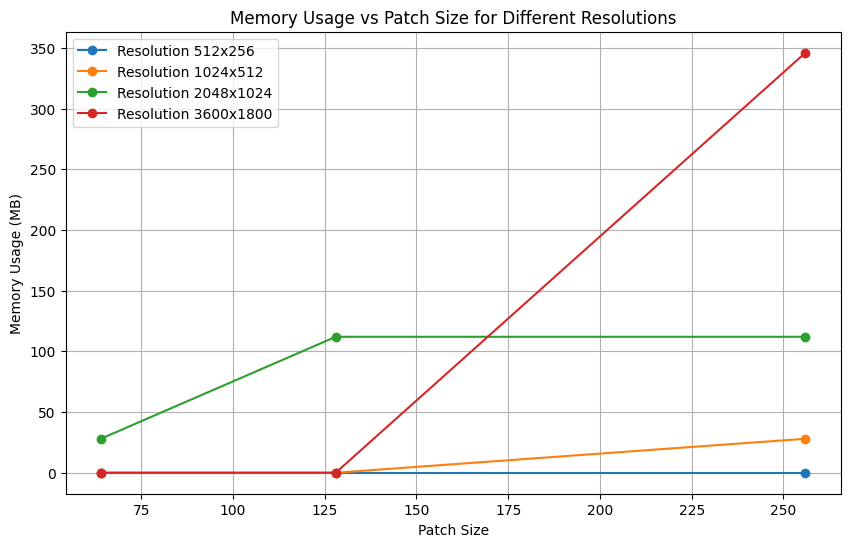

In [20]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Track memory before the attention layer
        mem_before_attn = torch.cuda.memory_allocated()
        attn_out, _ = self.attn(x, x, x)
        mem_after_attn = torch.cuda.memory_allocated()

        # Track memory after the attention layer
        x = self.norm1(x + self.dropout(attn_out))
        mem_after_norm1 = torch.cuda.memory_allocated()

        mlp_out = self.mlp(x)
        mem_after_mlp = torch.cuda.memory_allocated()

        x = self.norm2(x + self.dropout(mlp_out))
        mem_after_norm2 = torch.cuda.memory_allocated()

        return x


class WeatherPatchEmbedding(nn.Module):
    def __init__(self, grid_size=(256, 512), patch_size=16, in_channels=14, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches_h = grid_size[0] // patch_size
        self.num_patches_w = grid_size[1] // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        mem_before = torch.cuda.memory_allocated()
        x = self.projection(x)  # [B, embed_dim, H/P, W/P]
        mem_after = torch.cuda.memory_allocated()

        # Track memory consumed by this layer (in MB)
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        return x


class WeatherViT(nn.Module):
    def __init__(self, grid_size=(256, 512), patch_size=16, in_channels=14, embed_dim=256, num_heads=8, depth=6, mlp_dim=512):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches_h = grid_size[0] // patch_size
        self.num_patches_w = grid_size[1] // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w

        self.patch_embedding = WeatherPatchEmbedding(grid_size, patch_size, in_channels, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        self.lead_time_mlp = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

        self.transformer = nn.Sequential(*[TransformerBlock(embed_dim, num_heads, mlp_dim) for _ in range(depth)])
        self.decoder = nn.ConvTranspose2d(embed_dim, in_channels, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, lead_time):
        B = x.shape[0]
        # Track memory before patch embedding
        mem_before_patch = torch.cuda.memory_allocated()

        x = self.patch_embedding(x)
        mem_after_patch = torch.cuda.memory_allocated()

        # Track memory after patch embedding
        x += self.pos_embedding

        # Encode lead time
        if not torch.all((0 <= lead_time) & (lead_time <= 1440)):
            raise ValueError("Lead time must be between 0 and 1440 minutes")
        lead_time = lead_time.view(B, 1).float()  # Ensure shape [B, 1]
        lead_time_embed = self.lead_time_mlp(lead_time)  # [B, embed_dim]
        x += lead_time_embed.unsqueeze(1)  # Add lead time embedding

        # Track memory after lead time addition
        mem_after_lead_time = torch.cuda.memory_allocated()

        x = self.transformer(x)
        mem_after_transformer = torch.cuda.memory_allocated()

        # Track memory after transformer
        x = x.transpose(1, 2).reshape(B, -1, self.num_patches_h, self.num_patches_w)
        mem_after_reshape = torch.cuda.memory_allocated()

        x = self.decoder(x)  # Output shape: [B, 14, 256, 512]
        mem_after_decoder = torch.cuda.memory_allocated()


        return x

# Clear any previous memory cache
torch.cuda.empty_cache()

# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WeatherViT(grid_size=(256, 512), patch_size=16, in_channels=14).to(device)

# Generate random input data
x = torch.randn(8, 14, 256, 512).to(device)  # Batch size of 8, 14 channels, grid size 256x512
lead_time = torch.randint(1, 1441, (8, 1)).to(device)  # Random lead times for the batch

# Run the forward pass to track memory usage
output = model(x, lead_time)

del model


# Function to track memory usage
def track_memory_usage(model, x, lead_time):
    torch.cuda.empty_cache()  # Clear cache to avoid memory buildup
    start_memory = torch.cuda.memory_allocated()
    model(x, lead_time)
    end_memory = torch.cuda.memory_allocated()
    return abs((end_memory - start_memory) / (1024 ** 2))  # Convert to MB

# Example Resolutions to test
resolutions = [(512, 256), (1024, 512), (2048, 1024), (3600, 1800)]
batch_size = 1  # Example batch size

# Patch Sizes to test
patch_sizes = [64, 128, 256]  # Testing different patch sizes

# Dictionary to store memory usage for each resolution
memory_usage_patch_size = {f"{w}x{h}": [] for w, h in resolutions}

# Collect memory usage for different patch sizes for each resolution
for res in resolutions:
    for patch_size in patch_sizes:
        torch.cuda.empty_cache()  # Clear cache before instantiating new model

        # Instantiate model on GPU
        model = WeatherViT(grid_size=res, patch_size=patch_size, in_channels=14).to('cuda')

        # Create random input tensor and random lead time
        x = torch.randn(batch_size, 14, *res).to('cuda')
        lead_time = torch.randint(1, 1441, (batch_size, 1)).to('cuda')

        # Measure memory usage
        memory = track_memory_usage(model, x, lead_time)
        memory_usage_patch_size[f"{res[0]}x{res[1]}"].append(memory)

        # Free the memory of the model after the test
        del model
        torch.cuda.empty_cache()  # Clear cache to prevent memory buildup


# Plot Memory Usage vs Patch Size for different Resolutions
plt.figure(figsize=(10, 6))
for res in resolutions:
    plt.plot(patch_sizes, memory_usage_patch_size[f"{res[0]}x{res[1]}"], marker='o', linestyle='-', label=f'Resolution {res[0]}x{res[1]}')

plt.xlabel('Patch Size')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage vs Patch Size for Different Resolutions')
plt.legend()
plt.grid(True)
plt.show()

# Q3. Scalability with Number of Channels

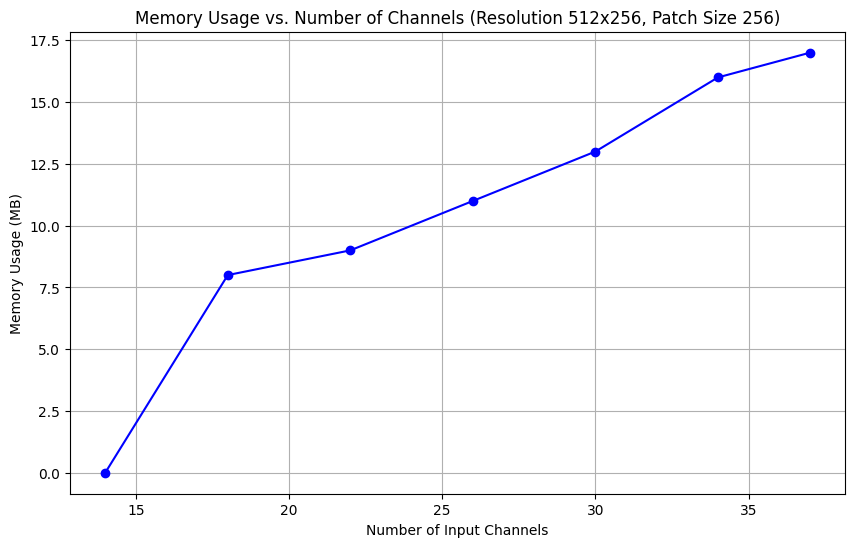

In [22]:
num_channels_list = [14, 18, 22, 26, 30, 34, 37]

#we fix these parameters
resolution = (512, 256)
batch_size = 1
patch_sizes = [16]

memory_usage_channels = []

for num_channels in num_channels_list:
    torch.cuda.empty_cache()  # Clear cache before testing

    # Instantiate model with varying number of channels
    model = WeatherViT(grid_size=resolution, patch_size=patch_size, in_channels=num_channels).to('cuda')

    # Create random input tensor and lead time
    x = torch.randn(batch_size, num_channels, *resolution).to('cuda')
    lead_time = torch.randint(1, 1441, (batch_size, 1)).to('cuda')

    # Measure memory usage
    memory = track_memory_usage(model, x, lead_time)
    memory_usage_channels.append(memory)

    # Free memory
    del model
    torch.cuda.empty_cache()

# Plot Memory Usage vs Number of Channels
plt.figure(figsize=(10, 6))
plt.plot(num_channels_list, memory_usage_channels, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Input Channels')
plt.ylabel('Memory Usage (MB)')
plt.title(f'Memory Usage vs. Number of Channels (Resolution {resolution[0]}x{resolution[1]}, Patch Size {patch_size})')
plt.grid(True)
plt.show()